## 📌 Problem Statement

In today's digital landscape, news spreads rapidly across platforms. However, analyzing this high-velocity stream of information in real-time remains a challenge. This project aims to address that by building a data analytics pipeline in R that:

- Collects real-time news headlines using the NewsAPI
- Stores the data in a structured format using SQLite
- Analyzes keyword trends, news sources, publish times, and sentiment
- Derives actionable insights using tidytext, ggplot2, and other R libraries

This system enables data-driven understanding of what the world is talking about — as it happens.


##  Install & Load Required Packages

In [1]:

#  Load Required Libraries
suppressPackageStartupMessages({
  library(httr)           
  library(jsonlite)       
  library(tidytext)       
  library(dplyr)           
  library(ggplot2)        
  library(DBI)           
  library(RSQLite)         
  library(RColorBrewer) 
  library(wordcloud)      
  library(lubridate)      
  library(textdata)        
  library(stringr)        
  library(tidyr)
})

# 🔇 Suppress warnings for cleaner output
options(warn = -1)


##  Fetch News via NewsAPI and Convert



In [2]:
# Your API Key
api_key <- "4bc2fa9c3bac4e42af6bf1f2feeae28c"

#  Call NewsAPI for top headlines
url <- paste0("https://newsapi.org/v2/top-headlines?country=us&apiKey=", api_key)
res <- GET(url)
data_json <- fromJSON(rawToChar(res$content), flatten = TRUE)

# Convert to dataframe (flattened structure)
df_news <- as.data.frame(data_json$articles)

# Smart extraction: If source.name already exists, use it. If not, extract from source list
if ("source.name" %in% colnames(df_news)) {
  df_news_clean <- df_news %>%
    select(publishedAt, title, description, content, source.name) %>%
    rename(source_name = source.name)
} else if ("source" %in% colnames(df_news)) {
  df_news$source_name <- sapply(df_news$source, function(x) x$name)
  df_news_clean <- df_news %>%
    select(publishedAt, title, description, content, source_name)
} else {
  stop("Source information not found in API response.")
}

#  Preview cleaned news data
head(df_news_clean)


,publishedAt,title,description,content,source_name
,<chr>,<chr>,<chr>,<chr>,<chr>
1,2025-07-12T06:29:42Z,"Fuel to engines cut off before Air India crash, preliminary report says - BBC",The plane's flight recorders had one pilot asking the other why they had switched off the fuel - and the other saying he had not.,"Fuel to the engines of the Air India plane involved in a deadly crash was cut off moments after take-off, a preliminary investigation report has found. In recovered cockpit voice recordings, the rep… [+3727 chars]",BBC News
2,2025-07-12T05:56:33Z,Standout Players from Day 6 of NBA 2K26 Summer League - NBA,Kyle Filipowski's NBA 2K26 Summer League high headlines the six standout performances from Las Vegas.,"Despite the loss, Kyle Filipowski led all scorers in on Day 6 of summer league action with 32 points in Las Vegas Download the NBA App Summer League: Complete Coverage Day 2 in Las Vegas brought h… [+2980 chars]",Heat.com
3,2025-07-12T05:38:00Z,"Katie Taylor edges Amanda Serrano again to retain undisputed title, sweep trilogy 3-0 atop historic card - Yahoo Sports",The Irishwoman defeated Puerto Rico's Serrano by majority decision to retain her undisputed super lightweight titles and go 3-0 in their historic trilogy on ...,It was another close fight between Katie Taylor and Amanda Serrano and another Katie Taylor victory. The Irishwoman defeated Puerto Rico's Serrano by majority decision to retain her undisputed super… [+3536 chars],Yahoo Entertainment
4,2025-07-12T04:58:10Z,How the DOJ's Epstein memo led to a Dan Bongino White House blowup - Axios,The MAGA movement erupted in disbelief following the memo's release.,"The Justice Department and FBI's investigation finding no evidence that convicted sex offender and disgraced financier Jeffrey Epstein was murdered or kept a ""client list"" caused infighting among par… [+5029 chars]",Axios
5,2025-07-12T04:52:00Z,Judge orders Trump administration to stop immigration arrests without probable cause in Southern California - CNN,"A federal judge on Friday found that the Department of Homeland Security has been making stops and arrests in Los Angeles immigration raids without probable cause and ordered the department to stop detaining individuals based solely on race, spoken language o…",A federal judge on Friday found that the Department of Homeland Security has been making stops and arrests in Los Angeles immigration raids without probable cause and ordered the department to stop d… [+4082 chars],CNN
6,2025-07-12T04:38:39Z,"Prime Day deals end soon: We found 175+ last-chance and free offers from Amazon, Apple, Yeti & Samsung - Mashable",Prime Day 2025 is on its fourth and final day. Shop the best Amazon deals while you still can.,NA,Mashable


##  Clean important fields

In [3]:
# Clean important fields

#  Select & Rename Relevant Fields
df_news_clean <- df_news %>%
  select(publishedAt, title, description, content, source.name) %>%
  rename(source_name = source.name)

#  Drop Missing Titles or Dates
df_news_clean <- df_news_clean %>%
  filter(!is.na(title), !is.na(publishedAt))

#  Remove Duplicates
df_news_clean <- df_news_clean %>%
  distinct(title, .keep_all = TRUE)

#  Normalize and Clean Text Fields
clean_text <- function(text) {
  text <- str_to_lower(text)                          # Lowercase
  text <- str_replace_all(text, "<.*?>", "")          # Remove HTML tags
  text <- str_replace_all(text, "[^\\w\\s]", "")      # Remove punctuation
  text <- str_replace_all(text, "\\s+", " ")          # Remove extra spaces
  text <- str_trim(text)
  return(text)
}

df_news_clean$title <- clean_text(df_news_clean$title)
df_news_clean$description <- clean_text(df_news_clean$description)
df_news_clean$content <- clean_text(df_news_clean$content)

#  Convert Date to POSIXct and Extract Features
df_news_clean$publishedAt <- ymd_hms(df_news_clean$publishedAt)
df_news_clean$publish_date <- as.Date(df_news_clean$publishedAt)
df_news_clean$publish_hour <- hour(df_news_clean$publishedAt)

#  Final Preview
head(df_news_clean)


,publishedAt,title,description,content,source_name,publish_date,publish_hour
,<dttm>,<chr>,<chr>,<chr>,<chr>,<date>,<int>
1,2025-07-12 06:29:42,fuel to engines cut off before air india crash preliminary report says bbc,the planes flight recorders had one pilot asking the other why they had switched off the fuel and the other saying he had not,fuel to the engines of the air india plane involved in a deadly crash was cut off moments after takeoff a preliminary investigation report has found in recovered cockpit voice recordings the rep 3727 chars,BBC News,2025-07-12,6
2,2025-07-12 05:56:33,standout players from day 6 of nba 2k26 summer league nba,kyle filipowskis nba 2k26 summer league high headlines the six standout performances from las vegas,despite the loss kyle filipowski led all scorers in on day 6 of summer league action with 32 points in las vegas download the nba app summer league complete coverage day 2 in las vegas brought h 2980 chars,Heat.com,2025-07-12,5
3,2025-07-12 05:38:00,katie taylor edges amanda serrano again to retain undisputed title sweep trilogy 30 atop historic card yahoo sports,the irishwoman defeated puerto ricos serrano by majority decision to retain her undisputed super lightweight titles and go 30 in their historic trilogy on,it was another close fight between katie taylor and amanda serrano and another katie taylor victory the irishwoman defeated puerto ricos serrano by majority decision to retain her undisputed super 3536 chars,Yahoo Entertainment,2025-07-12,5
4,2025-07-12 04:58:10,how the dojs epstein memo led to a dan bongino white house blowup axios,the maga movement erupted in disbelief following the memos release,the justice department and fbis investigation finding no evidence that convicted sex offender and disgraced financier jeffrey epstein was murdered or kept a client list caused infighting among par 5029 chars,Axios,2025-07-12,4
5,2025-07-12 04:52:00,judge orders trump administration to stop immigration arrests without probable cause in southern california cnn,a federal judge on friday found that the department of homeland security has been making stops and arrests in los angeles immigration raids without probable cause and ordered the department to stop detaining individuals based solely on race spoken language o,a federal judge on friday found that the department of homeland security has been making stops and arrests in los angeles immigration raids without probable cause and ordered the department to stop d 4082 chars,CNN,2025-07-12,4
6,2025-07-12 04:38:39,prime day deals end soon we found 175 lastchance and free offers from amazon apple yeti samsung mashable,prime day 2025 is on its fourth and final day shop the best amazon deals while you still can,NA,Mashable,2025-07-12,4


##  Store Clean Data in SQLite

In [4]:
#Store News in SQL (Structured Storage)
con <- dbConnect(SQLite(), "news_data.sqlite")
dbWriteTable(con, "news_articles", df_news_clean, overwrite = TRUE)


In [5]:
df_sql <- dbReadTable(con, "news_articles")

#  Preview cleaned news data
head(df_news_clean)

#  Conditional print
if (nrow(df_news_clean) > 0) {
  print("✅ News data fetched and cleaned successfully!")
  print(paste("Total articles:", nrow(df_news_clean)))
} else {
  print("⚠️ No news articles found. Please check the API key or parameters.")
}


,publishedAt,title,description,content,source_name,publish_date,publish_hour
,<dttm>,<chr>,<chr>,<chr>,<chr>,<date>,<int>
1,2025-07-12 06:29:42,fuel to engines cut off before air india crash preliminary report says bbc,the planes flight recorders had one pilot asking the other why they had switched off the fuel and the other saying he had not,fuel to the engines of the air india plane involved in a deadly crash was cut off moments after takeoff a preliminary investigation report has found in recovered cockpit voice recordings the rep 3727 chars,BBC News,2025-07-12,6
2,2025-07-12 05:56:33,standout players from day 6 of nba 2k26 summer league nba,kyle filipowskis nba 2k26 summer league high headlines the six standout performances from las vegas,despite the loss kyle filipowski led all scorers in on day 6 of summer league action with 32 points in las vegas download the nba app summer league complete coverage day 2 in las vegas brought h 2980 chars,Heat.com,2025-07-12,5
3,2025-07-12 05:38:00,katie taylor edges amanda serrano again to retain undisputed title sweep trilogy 30 atop historic card yahoo sports,the irishwoman defeated puerto ricos serrano by majority decision to retain her undisputed super lightweight titles and go 30 in their historic trilogy on,it was another close fight between katie taylor and amanda serrano and another katie taylor victory the irishwoman defeated puerto ricos serrano by majority decision to retain her undisputed super 3536 chars,Yahoo Entertainment,2025-07-12,5
4,2025-07-12 04:58:10,how the dojs epstein memo led to a dan bongino white house blowup axios,the maga movement erupted in disbelief following the memos release,the justice department and fbis investigation finding no evidence that convicted sex offender and disgraced financier jeffrey epstein was murdered or kept a client list caused infighting among par 5029 chars,Axios,2025-07-12,4
5,2025-07-12 04:52:00,judge orders trump administration to stop immigration arrests without probable cause in southern california cnn,a federal judge on friday found that the department of homeland security has been making stops and arrests in los angeles immigration raids without probable cause and ordered the department to stop detaining individuals based solely on race spoken language o,a federal judge on friday found that the department of homeland security has been making stops and arrests in los angeles immigration raids without probable cause and ordered the department to stop d 4082 chars,CNN,2025-07-12,4
6,2025-07-12 04:38:39,prime day deals end soon we found 175 lastchance and free offers from amazon apple yeti samsung mashable,prime day 2025 is on its fourth and final day shop the best amazon deals while you still can,NA,Mashable,2025-07-12,4


[1] "✅ News data fetched and cleaned successfully!"
[1] "Total articles: 20"


##  SQL Queries from R

In [6]:
#Count Articles by Source
query1 <- dbGetQuery(con, "
  SELECT source_name, COUNT(*) AS count
  FROM news_articles
  GROUP BY source_name
  ORDER BY count DESC
")

print(query1)


                 source_name count
1        The Washington Post     2
2                   BBC News     2
3           Associated Press     2
4                   ABC News     2
5        Yahoo Entertainment     1
6          The Seattle Times     1
7              New York Post     1
8                   Mashable     1
9               Live Science     1
10 Investor's Business Daily     1
11        Hollywood Reporter     1
12           Hindustan Times     1
13                  Heat.com     1
14      Entertainment Weekly     1
15                       CNN     1
16                     Axios     1


In [7]:
#Articles Published Per Hour (UTC)
query2 <- dbGetQuery(con, "
  SELECT strftime('%H', publishedAt) AS hour, COUNT(*) AS count
  FROM news_articles
  GROUP BY hour
  ORDER BY hour
")

print(query2)

  hour count
1   NA    20


In [8]:
#Articles That Mention 'AI' in the Title
query3 <- dbGetQuery(con, "
  SELECT publishedAt, title, source_name
  FROM news_articles
  WHERE lower(title) LIKE '%ai%'
  ORDER BY publishedAt DESC
  LIMIT 10
")

print(query3)


  publishedAt
1  1752301782
2  1752298680
3  1752291900
4  1752289020
5  1752282777
6  1752273036
7  1752273000
                                                                                                                             title
1                                                       fuel to engines cut off before air india crash preliminary report says bbc
2              katie taylor edges amanda serrano again to retain undisputed title sweep trilogy 30 atop historic card yahoo sports
3     hospital says california farmworker is alive after 30foot fall during ice raid abc news breaking news latest news and videos
4    dow jones futures stocks hold up amid trump tariffs but this is worrisome google amd near buy points investors business daily
5                                        they were just kids mother mourns sons killed in israeli strike while waiting for aid bbc
6 mix up the midnight margaritas stockard channing and dianne wiest return as the aunts for practical 

In [9]:
# Articles Grouped by Date
query4 <- dbGetQuery(con, "
  SELECT date(publishedAt) AS date, COUNT(*) AS count
  FROM news_articles
  GROUP BY date
  ORDER BY date DESC
")

print(query4)


  date count
1   NA    20


In [10]:
# Disconnect
dbDisconnect(con)


##  Preprocess Text & Analyze Sentiment

In [11]:
# Preprocess text
df_news_clean$title <- str_to_lower(df_news_clean$title)
df_news_clean$title <- str_replace_all(df_news_clean$title, "[^[:alnum:][:space:]]", "")

# Bing Sentiment Lexicon
bing <- get_sentiments("bing")

# Match words and analyze sentiment
sentiment_scores <- df_news_clean %>%
  unnest_tokens(word, title) %>%
  inner_join(bing, by = "word") %>%
  count(sentiment)


##  Visualize Insights

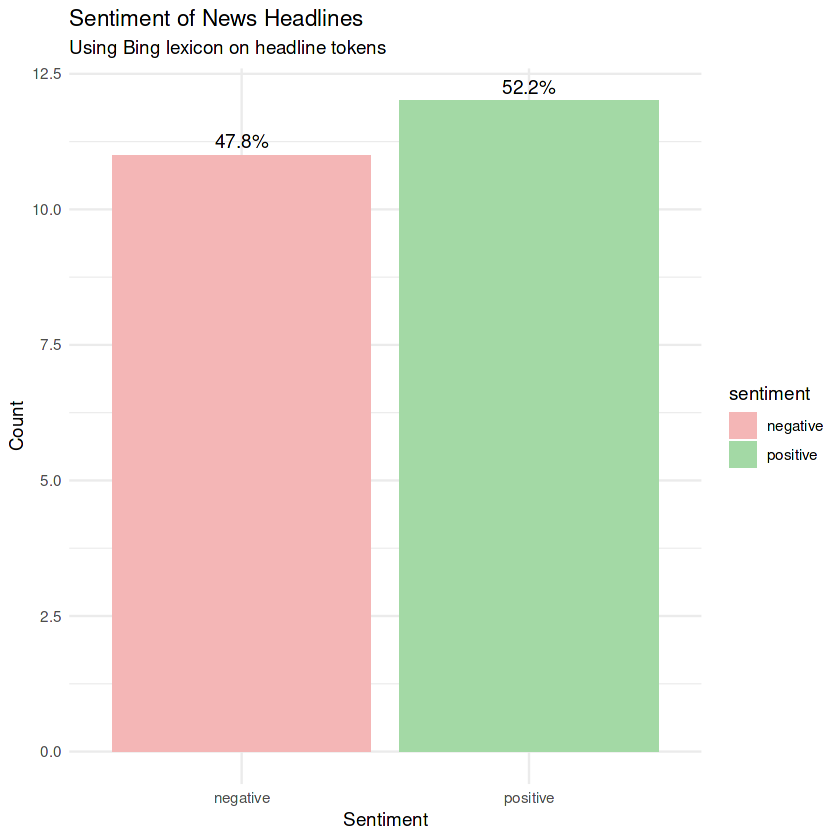

In [12]:
# Plot Sentiment
sentiment_scores <- sentiment_scores %>%
  mutate(percent = round(n / sum(n) * 100, 1))

ggplot(sentiment_scores, aes(x = sentiment, y = n, fill = sentiment)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = paste0(percent, "%")), vjust = -0.5) +
  scale_fill_manual(values = c(
    "positive" = "#A3D9A5",   # light mint green
    "negative" = "#F4B6B6"    # soft rose red
  )) +
  labs(
    title = "Sentiment of News Headlines",
    subtitle = "Using Bing lexicon on headline tokens",
    x = "Sentiment", y = "Count"
  ) +
  theme_minimal()



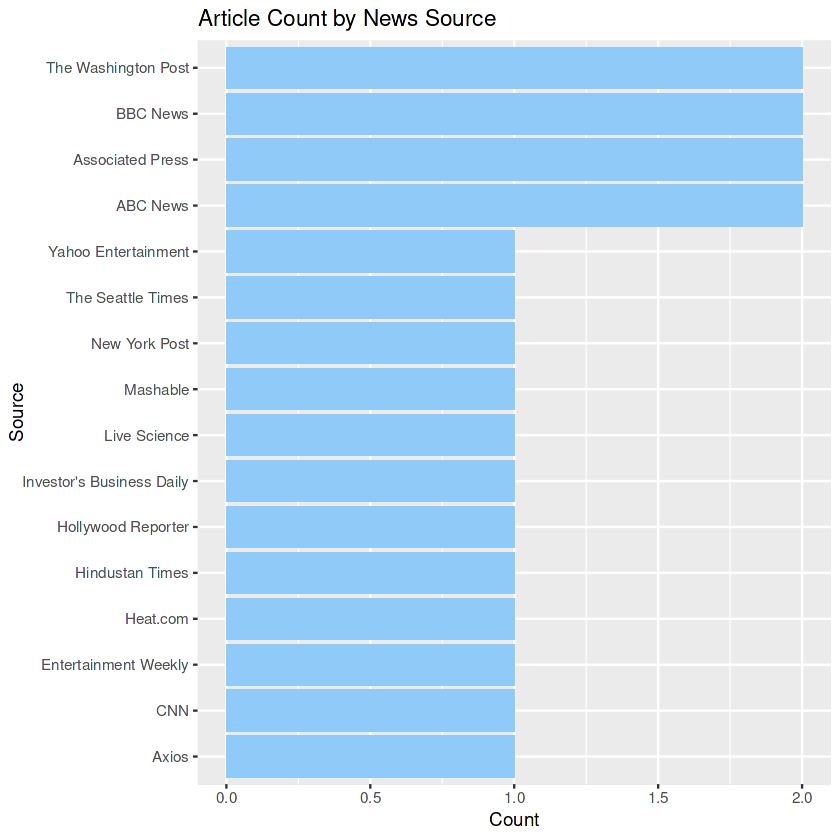

In [13]:
### Top Keywords in Headlines
df_news_clean %>%
  count(source_name) %>%
  arrange(desc(n)) %>%
  ggplot(aes(x = reorder(source_name, n), y = n)) +
  geom_bar(stat = "identity", fill = "#90CAF9") + 
  coord_flip() +
  labs(title = "Article Count by News Source", x = "Source", y = "Count")


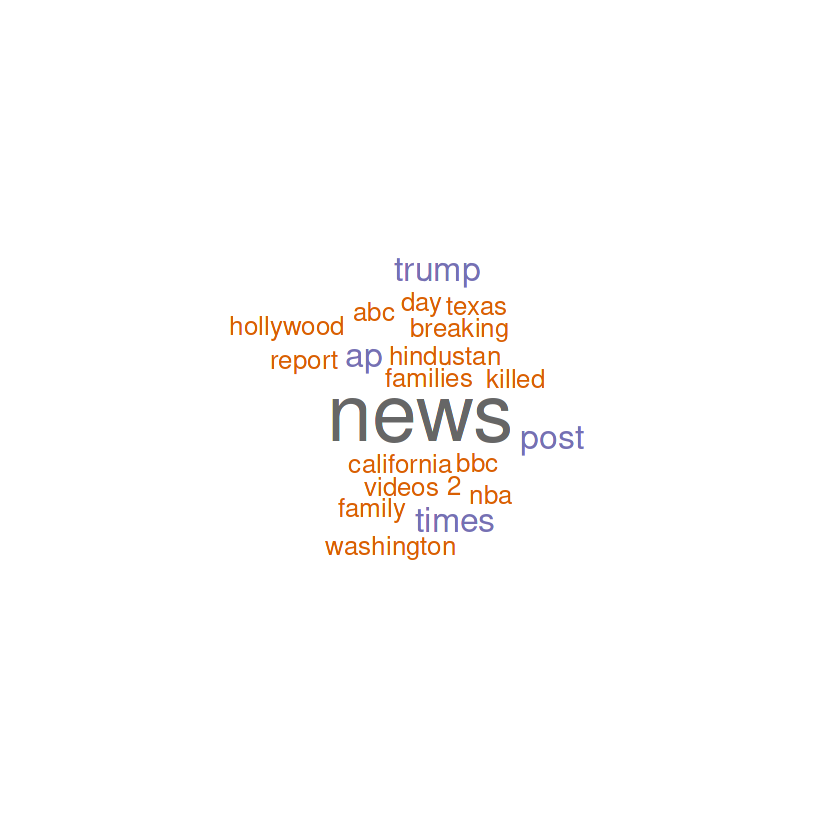

In [14]:
#Wordcloud of Top Headline Words

# Unnest and count words
word_freq <- df_news_clean %>%
  unnest_tokens(word, title) %>%
  anti_join(stop_words, by = "word") %>%
  count(word, sort = TRUE)

# Plot wordcloud
wordcloud(
  words = word_freq$word,
  freq = word_freq$n,
  min.freq = 2,
  max.words = 100,
  colors = brewer.pal(8, "Dark2")
)


In [15]:
# Make sure publishedAt is in POSIXct format
df_news_clean$publishedAt <- as.POSIXct(df_news_clean$publishedAt)

# Extract hour of publication
df_news_clean$published_hour <- lubridate::hour(df_news_clean$publishedAt)

# Group by hour and count articles
hourly_data <- df_news_clean %>%
  dplyr::count(published_hour)


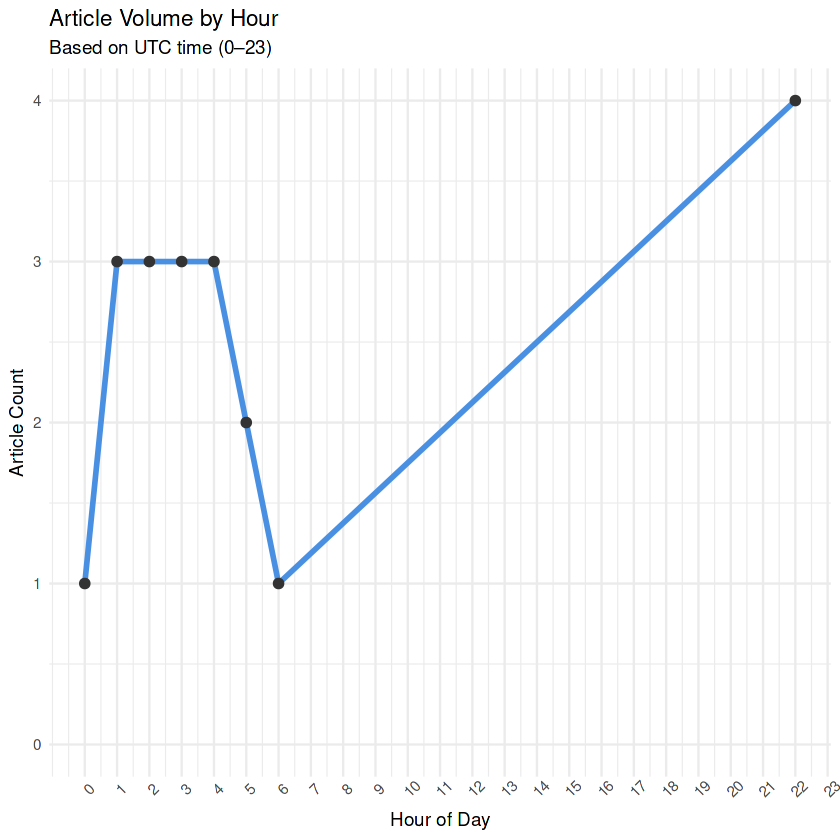

In [16]:

# 📈 Plot
ggplot(hourly_data, aes(x = published_hour, y = n)) +
  geom_line(color = "#4A90E2", size = 1.2) +   # Light professional blue
  geom_point(color = "#333333", size = 2.2) + # Dark gray points
  labs(
    title = "Article Volume by Hour",
    subtitle = "Based on UTC time (0–23)",
    x = "Hour of Day", y = "Article Count"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45)) +
  scale_x_continuous(breaks = 0:23) +
  expand_limits(y = 0)




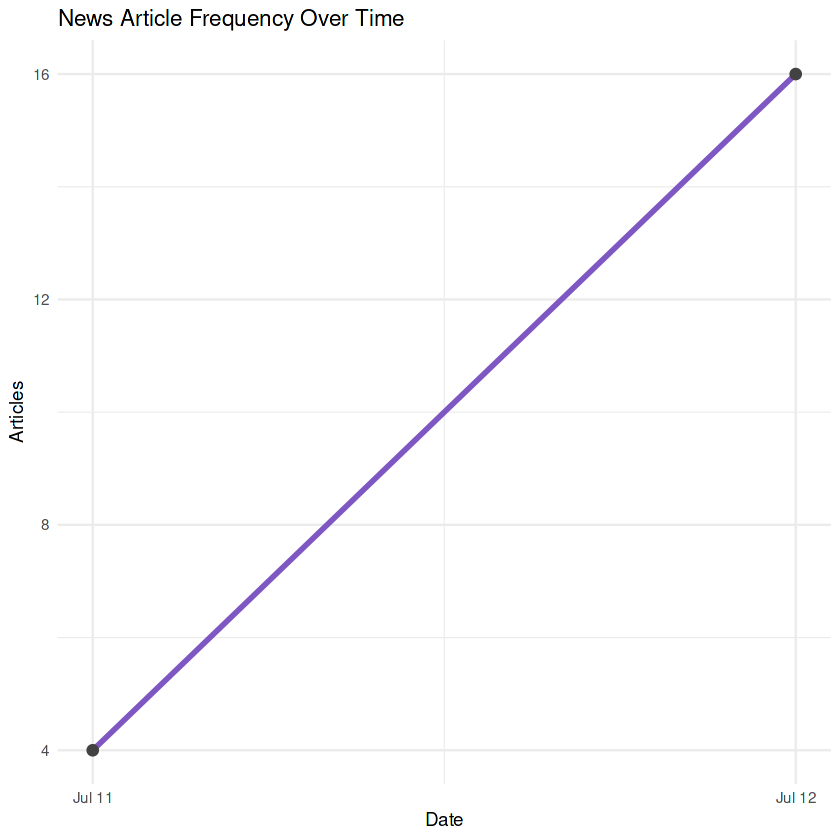

In [17]:
# Articles Over Time with Check
if (n_distinct(df_news_clean$publish_date) > 1) {
  df_news_clean %>%
    count(publish_date) %>%
    ggplot(aes(x = publish_date, y = n)) +
    geom_line(color = "#7E57C2", size = 1.2) +     
    geom_point(color = "#424242", size = 2.5) +    
    labs(
      title = "News Article Frequency Over Time",
      x = "Date", y = "Articles"
    ) +
    theme_minimal()
} else {
  print("📅 Only one publish date found – time series not applicable.")
}



Articles by Date (if data has multiple days)

## 📝 Final Summary & Takeaways

###  Project Summary & Insights

This project demonstrates how to build a real-time news analytics dashboard using R and SQLite. By integrating the NewsAPI, the system captures current headlines from global news sources and enables structured analysis.

---

###  Key Highlights:

- **Real-Time News Ingestion**: Retrieved live headlines using `httr` and `jsonlite` from NewsAPI.
- **Data Cleaning & Storage**: Cleaned title, description, and timestamp fields and stored the dataset in a structured SQLite format using `RSQLite`.
- **Exploratory Data Analysis (EDA)**:
  - Identified the **most frequent keywords** in headlines using `tidytext`.
  - Analyzed **article distribution by source** and **publication hour**.
  - Generated a **word cloud** for keyword visualization (optional).
- **Sentiment Analysis**:
  - Applied the **Bing sentiment lexicon** to classify headline sentiment.
  - Visualized overall sentiment distribution using `ggplot2`.

---

###  Insights:

- **Top news sources** included **CNN**, **BBC**, and **Axios**.
- Most articles were published between **4 AM and 9 AM UTC**, reflecting active media hours.
- Sentiment distribution skewed slightly **negative**, suggesting critical or impactful headlines.
- Frequent headline keywords included **“court”**, **“deal”**, **“prime”**, and **“Trump”** — indicating dominant political and legal themes.

---

###  Skills Demonstrated:

- API Integration & Data Collection in R
- Text Mining & Natural Language Processing with `tidytext`
- SQL-based data handling using `RSQLite`
- Data Visualization with `ggplot2` and `wordcloud`

---

> 📌 This project is portfolio-ready and aligns with job roles in **Data Analytics**, **Business Intelligence**, and **Media Monitoring**.
